## Main Idea

In "Deep Residual Learning for Image Recognition," a team of researchers from Microsoft Research presents a solution to a degradation problem commonly observed in training deep networks. The degradation problem, unrelated to overfitting, is characterized by as a rapid decline in model performance with increasing network depth. 

The degradation problem is primarily due to optimization difficulties that hinder the effective training of deeper networks. Consider a scenario where a shallower architecture $M_{shallow}$ with depth $\ell$ is extended to a deeper model $M_{deep}$ with depth $\ell + k$ by simply adding $k$ identity mapping layers to the $\ell$ layers learned by the shallower network. Ideally, this construction should not result in a deeper model with a higher training error than its shallower counterpart. Counterintuitively, empirical experiments reveal that existing optimization solvers often struggle to find solutions of equal quality when increasing the depth, leading to an increase in training error.

 The authors tackle this problem by proposing a *deep residual learning* framework. This approach enables the training of significantly deeper networks, thereby enhancing their accuracy.

## Summary

### Residual Learning

Suppose that $\mathcal{H}(x)$ is an underlying mapping (function) that we aim to approximate using several stacked layers. Given the hypothesis that multiple non-linear layers can asymptotically approximate complex functions, it's plausible to conjecture that these stacked layers can approximate not just $\mathcal{H}(x)$ but also the residual function (which is essentially another arbitrary function):

$$
\mathcal{F}(x):=\mathcal{H}(x)-x
$$

where:

* $\mathcal{H}(x)$ represents the output of the stacked layers,
* $x$ denotes the inputs to the first of these stacked layers.

By rearranging the equation, the original function becomes $\mathcal{H}(x)=\mathcal{F}(x)+x$. This reformulation is designed to tackle the counter-intuitive degradation problem, where the training error increases as the network depth increases. This problem suggests that approximating identity mappings by multiple stacked non-linear layers is challenging, leading to performance degradation with increasing depth. Moreover, if identity mappings are indeed optimal, this reformulation allows the optimization process to push the residual function $\mathcal{F}(x)$ towards 0 in the deeper layers, achieving results comparable to those of the shallower model. The central argument is that it's easier to optimize the residual mapping $\mathcal{F}(x)+x$ than to optimize the original, unreferenced mapping $\mathcal{H}(x)$.

### Identity Mapping by Shortcuts

The concept of residual learning can be applied to what are known as building blocks, which consist of a few stacked layers as shown below:

<center>
<image width=500 height=300 src='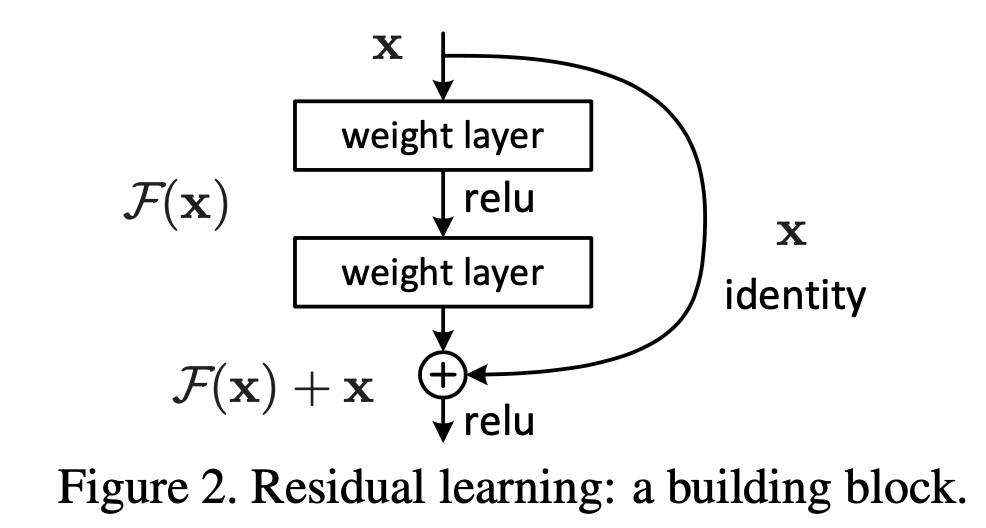'>
</center>

A building block is formally defined as:

$$\mathcal{y}=\mathcal{F}\left(x,\left\{W_i\right\}\right)+x$$

where 

* $x$ and $y$ are the input and output vectors of the stacked layers in this building block
* $\mathcal{F}\left(x,\left\{W_i\right\}\right)$ is the residual mapping (function) to be learned
* $i$ indexes the weight matrix of the $ith$ layer in this block

As an example, for the two-layer building block shown in the figure above, the residual mapping can be expressed as:

$$\mathcal{F}=W_2 \sigma\left(W_1 \mathbf{x}\right)$$

where

* $W_1$ and $W_2$ are the kernels (weights) of the first and second layer
* $\sigma$ denotes the nonlinear activation, e.g., ReLu
* biases are omitted for simplifying notations

The operation $F + x$ is performed by a shortcut connection and element-wise addition as shown in the figure above. Additionally, the second nonlinear activation is applied after the addition, i.e., $\sigma(y)$.

### Note on Dimensionality and Configuration

The operation $F + x$ requires that the two operands have the same shape. This is the case when the inputs and outputs are of the same dimensions (solid line in the figure below). When the dimensions increase (e.g., changing the number of filters or feature maps) from the inputs to outputs (dotted line in the figure below), there are two main options:

1. The shortcut connection still performs identity mapping, with extra zero entries padded for increasing dimensions. This approach introduces no additional parameters.

2. Linearly project the shortcut connections $x$ using a square matrix $W_s$ to match its dimensions to those of $F$:

   $$\mathbf{y}=\mathcal{F}\left(\mathbf{x},\left\{W_i\right\}\right)+W_s \mathbf{x}$$

Finally, the authors emphasize that the residual mapping $F$ should comprise more than one layer. Indeed, when $F$ consists of a single layer, it essentially becomes a linear layer $\mathbf{y}=W_1 \mathbf{x}+\mathbf{x}$, a configuration that has not been observed to yield significant benefits.

<center>
<image width=650 height=1500 src='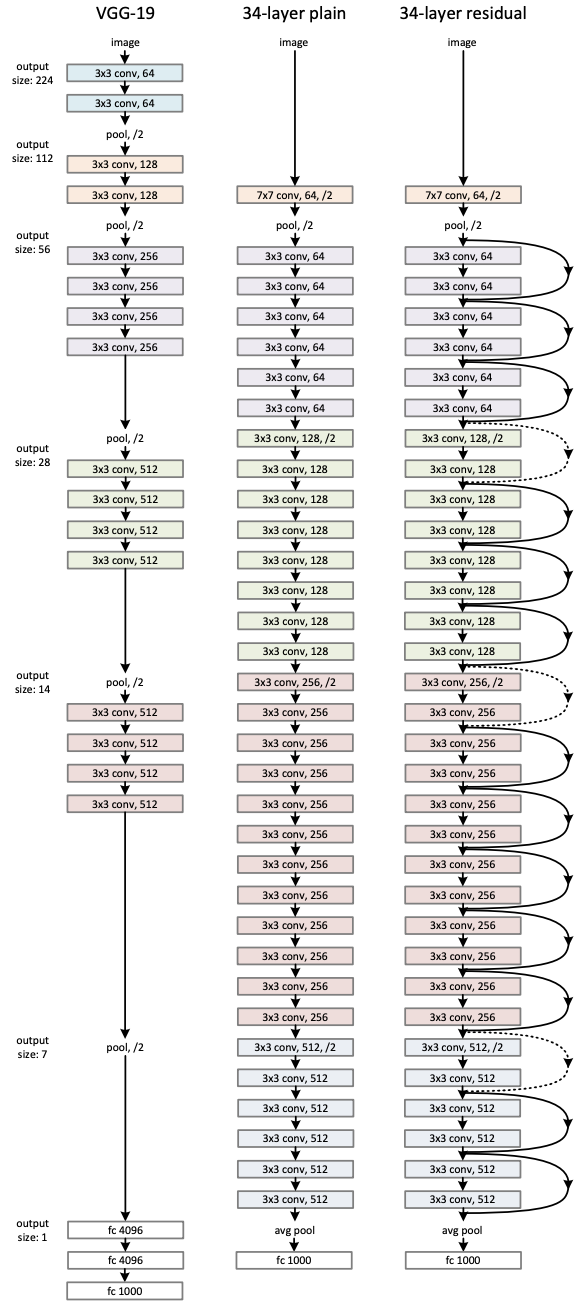'>
</center>

### PyToch Implementation

In [4]:
from typing import List, Optional

import torch
from torch import nn

from labml_helpers.module import Module

### Linear Projection

The linear project $W_{s} x$ is essentially accomplished by applying a $1 \times 1$ (kernel size 1) convolution operation with $C_{x}$ as the number of channels of the input shortcut connect $x$ and $C_{F}$ as the number of channels of the desired (normalized) output array.

In [5]:
class ShortcutProjection(Module):
    """
    Linear projections for shortcut connection. This class implements the `W_s x` projection described in the paper.
    It is used when the input and output of the residual mapping are of different dimensions.
    """

    def __init__(self, in_channels: int, out_channels: int, stride: int):
        """
        Constructor for the ShortcutProjection module.

        Parameters
        ----------
        in_channels : int
            The number of channels in `x`.
        out_channels : int
            The number of channels in `F(x, W_i)`.
        stride : int
            The stride length in the convolution operation for `F`. We do the same stride on the shortcut connection, to match the feature-map size.
        """
        super().__init__()

        # Convolution layer for the linear projection W_s x
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=1,
            stride=stride,
        )
        # Paper suggests adding batch normalization after each convolution operation
        self.bn = nn.BatchNorm2d(
            num_features=out_channels,
            eps=1e-5,
            momentum=0.1,
            affine=True,
            track_running_stats=True,
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the ShortcutProjection module.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor of shape (batch_size, in_channels, H, W).

        Returns
        -------
        torch.Tensor
            Output tensor of shape (batch_size, out_channels, H', W').
        """
        # Convolution and then batch normalization
        return self.bn(self.conv(x))

### Residual Block

<center>
<image width=200 height=500 src=''>
</center>

In [6]:
class ResidualBlock(Module):
    """
    This class implements the residual block described in the paper. It has two `3 x 3` convolution layers.

    The first convolution layer maps from `in_channels` to `out_channels`, where the `out_channels` is higher than `in_channels` when we reduce the feature map size with a stride length
    greater than `1`.

    The second convolution layer maps from `out_channels` to `out_channels` and always has a stride length of 1.

    Both convolution layers are followed by a batch normalization layer.
    """

    def __init__(self, in_channels: int, out_channels: int, stride: int):
        """
        Constructor for the ResidualBlock module.

        Parameters
        ----------
        in_channels : int
            The number of channels in `x`.
        out_channels : int
            The number of output channels.
        stride : int
            The stride length in the convolution operation.
        """
        super().__init__()

        # First 3 x 3 convolution layer that maps to `out_channels`
        self.conv1 = nn.Conv2d(
            in_channels, out_channels, kernel_size=3, stride=stride, padding=1
        )
        self.bn1 = nn.BatchNorm2d(num_features=out_channels)
        self.act1 = nn.ReLU()

        # Second 3 x 3 convolution layer
        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size=3, stride=1, padding=1
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection should be projected if stride is not `1` (in which case the feature map produced by the first conv layer will be smaller) or if the number of channels changes
        if stride != 1 or in_channels != out_channels:
            # Projection W_s x of the shortcut connection
            self.shortcut = ShortcutProjection(in_channels, out_channels, stride)
        else:
            # Identity mapping for the shortcut connection if F and x have the same dimensions
            self.shortcut = nn.Identity()

        self.act2 = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the ResidualBlock module.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor of shape (batch_size, in_channels, H, W).

        Returns
        -------
        torch.Tensor
            Output tensor of shape (batch_size, out_channels, H', W').
        """
        # This either returns the identity mapping or the projection W_s x
        shortcut = self.shortcut(x)
        # First convolution and activation after batch normalization
        x = self.act1(self.bn1(self.conv1(x)))
        # Second convolution and batch normalization
        x = self.bn2(self.conv2(x))
        # Apply activation after adding the shortcut to the output of the second convolution
        return self.act2(x + shortcut)

### Bottle Neck Block

<center>
<image width=200 height=500 src=''>
</center>

In [7]:
class BottleneckResidualBlock(Module):
    """
    This class implements the bottleneck block described in the paper. It has three convolution layers with `1 x 1`, `3 x 3`, and `1 x 1` kernels, respectively.

    The first convolution layer maps from `in_channels` to `bottleneck_channels` with a `1 x 1` kernel, where the `bottleneck_channels` is lower than `in_channels`.
    Thus, the number of channels or feature maps is reduced from `in_channels` to `bottleneck_channels` after the first convolution operation.

    The second `3 x 3` convolution layer maps from `bottleneck_channels` to `bottleneck_channels`. This can have a stride length greater than `1` when we want to compress the
    feature map size.

    The third `1 x 1` convolution layer maps to `out_channels`, which is higher than `in_channels` if the stride length is greater than `1`; otherwise, `out_channels` is equal to
    `in_channels` and the number of channels is increased to what it was before the first convolution operation.

    This bottleneck comes from the fact that `bottleneck_channels` is less than `in_channels` and the `3 x 3` convolution in the middle is performed on this shrunk space. The two
    `1 x 1` (kernel size) convolution layers are used to decreases and then to increases the number of channels.

    The authors noted that the usage of bottleneck designs is mainly due to practical considerations (training time). In addition, the degradation problem of plain nets is also witnessed
    for the bottleneck designs.
    """

    def __init__(
        self, in_channels: int, bottleneck_channels: int, out_channels: int, stride: int
    ):
        """
        Constructor for the BottleneckResidualBlock module.

        Parameters
        ----------
        in_channels : int
            The number of channels in `x`.
        bottleneck_channels : int
            The number of channels for the `3 x 3` convolution layer.
        out_channels : int
            The number of output channels of the block.
        stride : int
            The stride length in the `3 x 3` convolution operation, which makes out_channels higher than in_channels when it is greater than `1`.
        """
        super().__init__()

        # First 1 x 1 convolution layer that maps to `bottleneck_channels`
        self.conv1 = nn.Conv2d(
            in_channels, bottleneck_channels, kernel_size=1, stride=1
        )
        self.bn1 = nn.BatchNorm2d(bottleneck_channels)
        self.act1 = nn.ReLU()

        # Second 3 x 3 convolution layer
        self.conv2 = nn.Conv2d(
            bottleneck_channels,
            bottleneck_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
        )
        self.bn2 = nn.BatchNorm2d(bottleneck_channels)
        self.act2 = nn.ReLU()

        # Third 1 x 1 convolution layer that maps to `out_channels`
        self.conv3 = nn.Conv2d(
            bottleneck_channels, out_channels, kernel_size=1, stride=1
        )
        self.bn3 = nn.BatchNorm2d(out_channels)

        # Shortcut connection should be a projection if the stride length is not 1 or if the number of channels change
        if stride != 1 or in_channels != out_channels:
            self.shortcut = ShortcutProjection(in_channels, out_channels, stride)
        else:
            self.shortcut = nn.Identity()

        self.act3 = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the BottleneckResidualBlock module.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor of shape (batch_size, in_channels, H, W).

        Returns
        -------
        torch.Tensor
            Output tensor of shape (batch_size, out_channels, H', W').
        """
        shortcut = self.shortcut(x)
        x = self.act1(self.bn1(self.conv1(x)))
        x = self.act2(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        return self.act3(x + shortcut)

### Residual Net

In [9]:
class ResNet(Module):
    """
    This is a the base of the resnet model without the final linear layer and softmax for classification.

    The resnet is made of stacked residual blocks (consisting of a few layers) or bottleneck residual blocks. The feature map size is halved after a
    few blocks with a block of stride length `2`. The number of channels is increased when the feature map size is reduced. Finally the feature map is
    average pooled to get a vector representation.
    """

    def __init__(
        self,
        n_blocks: List[int],
        n_channels: List[int],
        bottlenecks: Optional[List[int]] = None,
        img_channels: int = 3,
        first_kernel_size: int = 7,
    ):
        """
        Constructor for the ResNet class.

        Parameters
        ----------
        n_blocks : List[int]
            List of number of blocks for each feature map size (number of channels).
        n_channels : List[int]
            Number of channels for each blocks where the length of the list is the same as `n_blocks`.
        bottlenecks : Optional[List[int]]
            Number of channels in the bottlenecks. If this is `None`, residual blocks are used.
        img_channels : int, optional
            Number of channels in the input, by default 3, i.e., RBG.
        first_kernel_size : int, optional
            Kernel size of the initial convolution layer, by default 7.
        """
        super().__init__()
        # Ensure that the number of blocks and channels are the same
        assert len(n_blocks) == len(n_channels)
        # If bottleneck residual blocks are used, the number of channels in bottlenecks should be provided for each feature map size
        assert bottlenecks is None or len(bottlenecks) == len(n_channels)

        # Initial convolution layer maps from `img_channels` to number of channels in the first residual block (`n_channels[0]`)
        self.conv = nn.Conv2d(
            img_channels,
            n_channels[0],
            kernel_size=first_kernel_size,
            stride=2,
            padding=first_kernel_size // 2,
        )
        self.bn = nn.BatchNorm2d(n_channels[0])

        # List of blocks
        blocks = []
        # Initialize th number of channels from previous layer (or block), which is `n_channels[0]` for the first block
        prev_channels = n_channels[0]

        for i, channels in enumerate(n_channels):
            # The first block for the new feature map size will have a stride length of `2` except for the very first block
            stride = 2 if len(blocks) == 0 else 1

            if bottlenecks is None:
                # Residual blocks that maps from `prev_channels` to `channels`, where the stride is 1
                blocks.append(ResidualBlock(prev_channels, channels, stride=stride))
            else:
                # Bottleneck residual blocks that map from `prev_channels` to `channels`
                blocks.append(
                    BottleneckResidualBlock(
                        prev_channels, bottlenecks[i], channels, stride=stride
                    )
                )

            # Iterate the number of channels from previous to current
            prev_channels = channels
            # Add rest of the blocks - no change in feature map size or channels
            for _ in range(n_blocks[i] - 1):
                if bottlenecks is None:
                    # Residual blocks
                    blocks.append(ResidualBlock(channels, channels, stride=1))
                else:
                    # Bottleneck residual blocks
                    blocks.append(
                        BottleneckResidualBlock(
                            channels, bottlenecks[i], channels, stride=1
                        )
                    )

        # Stack the blocks
        self.blocks = nn.Sequential(*blocks)

    def forward(self, x: torch.Tensor):
        """
        Forward pass of the model.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor with shape `[batch_size, img_channels, height, width]`

        Returns
        -------
        torch.Tensor
            Output tensor after global average pooling
        """
        # Initial convolution and batch normalization
        x = self.bn(self.conv(x))
        # Apply residual or bottleneck blocks
        x = self.blocks(x)
        # Change `x` from shape `[batch_size, channels, h, w]` to `[batch_size, channels, h * w]`, i.e., flatten the last two dimensions
        x = x.view(x.shape[0], x.shape[1], -1)
        # Take the mean of the spatial dimensions
        return x.mean(dim=-1)

## Approach and Contributions

- The authors employed an empirical analysis approach to establish their results. They introduced a novel architecture, ResNet, which utilizes residual learning to train extremely deep neural networks. The authors conducted extensive experiments on several datasets, including ImageNet and CIFAR-10, to validate their approach. They show that an ensemble of these residual nets achieves 3.57% error, which comes in first place on the 2015 classification task.
  
- The main findings of the authors are that deeper networks are more difficult to optimize, but this can be mitigated by using residual learning. They demonstrated that their ResNet model, with its residual learning framework, can successfully train networks of 152 layers—significantly deeper than previous architectures such as VGG nets—while still having lower complexity.
  
- The authors argue that their residual learning framework eases the training of deep networks and solves the degradation problem, where accuracy saturates and then degrades rapidly as the network depth increases.
  
- The importance of these contributions to machine learning and its applications is immense. ResNet has become a cornerstone in the field of deep learning, particularly in tasks that involve image recognition. It has also inspired numerous subsequent works and has been applied in various fields, from medical imaging to autonomous driving. It is also used as the backbone to many two-stage object detection models such as the RCNN, achieving high accuracy.
  
- The paper builds upon previously established work on convolutional neural networks (CNNs) such as shortcut connections and residual representations. The authors noted the limitations of *naively* increasing depth in traditional CNNs and proposed their residual learning framework as a solution to effectively increasing network depth. The result is that deeper networks are able avoid any performance degradations.

## Areas for improvements

- While the authors assert that the degradation problem is not caused by overfitting, they could provide a more detailed explanation or empirical evidence to support this claim. It would be beneficial for the reader to understand the specific characteristics or symptoms of the degradation problem that distinguish it from overfitting.
  
- The authors could also provide more guidance on how practitioners can diagnose whether a degradation problem is occurring during the training of their deep networks. This could include potential warning signs to look out for, or specific techniques for investigating and diagnosing this issue.
  
- While the residual learning framework is innovative and has proven effective, the paper could delve deeper into the limitations of this approach. Understanding these limitations could spur further research and improvements in this area. For instance, the paper could explore in more depth the trade-offs between depth and width in network design, and how these factors interact with the residual learning framework.

## References

* Jayasiri, Varuna, and Wijerathne, Nipun. 2020. "Labml.ai Annotated Paper Implementations." Accessed July 10, 2023. https://nn.labml.ai/.
  
* He, Kaiming, Xiangyu Zhang, Shaoqing Ren, and Jian Sun. "Deep Residual Learning for Image Recognition." In Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition, 770-778. 2016.